# Lab 2 - Astronomical Spectroscopy

## Import libraries and define common functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn

In [2]:
def centroid(arr, bounds=None): # returns the centroid index for an array with optional bounds for computing the centroid
    if bounds is None: # computes centroid over the entire array
        return sum(range(len(arr)) * arr) / sum(arr)
    else: # computes centroid over the subset of the array within the given bounds
        arrBound = arr[bounds[0]:bounds[1]]
        return sum(range(len(arrBound)) * arrBound) / sum(arrBound) + bounds[0]

def leastSquaresFit(x, y): # computes the slope and intercept of a least squares regression line fitting the input data
    if len(x) != len(y): # raises an error if the arrays are not the same length
        raise ValueError('x and y must be the same size')
    else:
        # Construct the matrices
        ma = np.array([[np.sum(x**2), np.sum(x)], [np.sum(x), len(x)]])
        mc = np.array([[np.sum(x*y)], [np.sum(y)]])

        # Compute the gradient and intercept
        mai = np.linalg.inv(ma) # inverts matrix ma
        md = np.dot(mai,mc) # matrix multiply is dot

        return md[0,0], md[1,0]

In [3]:
# The end-all, be-all of centroid functions. It slices. It dices. It cuts. Ladies and gents, nCentroids does it all.
def nCentroids(arr, n=None, bounds=None, background=None, nsigma=10, cutoff=None): # returns a 1xn array of centroid indices
    if not(n is None) and n < 1: # n is the number of peaks to centroid, so if specified, it must be at least 1
        raise ValueError('n must be greater than or equal to 1')

    offset = 0
    if not(bounds is None): # resizes the array to only the values within the bounds while saving an offset to add to the final centroids
        arr = arr[bounds[0]:bounds[1]]
        offset = bounds[0]

    crosses = [] # to save the indices where arr crasses above or below the div or cutoff
    if (background is None and cutoff is None) or not(n is None): # this if-block to run when n is specified or when nothing is
        if not(background is None and cutoff is None): # prioritize the right number of peaks over using a background noise
            warn('background and cutoff are ignored when n is provided')
        
        # if n is unspecified at this point, then neither are background or cutoff, so we need some criteria to isolate peaks
        # by default, we find the centroid for the 1 largest peak
        if n is None: 
            n = 1
        
        div = (np.max(arr) + np.min(arr)) / 2 # sets divider at the midpoint of the data
        lastDiv = None
        peaks = 0
        while peaks != n:
            divArr = arr - div
            crosses = np.where(np.diff(np.sign(divArr)))[0] # identifies indices where arr goes from < to > div or vice versa
            if (len(crosses) % 2 != 0): # if it crosses an uneven number of times, the bounds may not fully contain a peak
                raise RuntimeError('the number of peaks could not be resolved within the bounds of arr')

            temp = div
            peaks = int(len(crosses) / 2) # What goes up must come down. For every peak there are 2 crosses of div
            # adjust div up or down according to whether there are too many or too few peaks above div
            if peaks < n:
                if lastDiv is None:
                    div -= abs(div - np.min(arr)) / 2
                else:
                    div -= abs(div - lastDiv) / 2
            elif peaks > n:
                if lastDiv is None:
                    div += abs(div + np.min(arr)) / 2
                else:
                    div += abs(div + lastDiv) / 2
            lastDiv = temp
    else: # occurs when using a cutoff or background to identify peaks
        if not(background is None) and not(cutoff is None):
            warn('background is ignored when cutoff is provided') # priority of use: n > cutoff > background
        if cutoff is None: # sets a cutoff based on the standard deviation and mean of the background and nsigma
            cutoff = nsigma*np.std(background) + np.mean(background) 
        divArr = arr - cutoff
        crosses = np.where(np.diff(np.sign(divArr)))[0] # identifies indices where arr goes from < to > cutoff or vice versa
        
    subBounds = np.array(np.reshape(crosses, (int(len(crosses)/2), 2))) # uses crosses as paired upper and lower bounds for centroids
    for i, abounds in enumerate(subBounds): # expands the bounds to make sure the full width of the peak is considered to determie centroid
        width = abs(abounds[0] - abounds[1])
        if i > 0:
            subBounds[i][0] = max(abounds[0] - width, subBounds[i-1][0]) # max prevents overlap with bounds of another peak
        else:
            subBounds[i][0] = abounds[0] - width
        
        if i < len(subBounds) - 1:
            subBounds[i][1] = min(abounds[1] + width, int((subBounds[i+1][0] + abounds[1])/2)) # min prevents overlap with bounds of another peak
        else:
            subBounds[i][1] = abounds[1] + width

    # computes the centroids for arr in each of the bound regions
    centroids = np.array([centroid(arr, abounds) + offset for abounds in subBounds])
    return centroids

## Data Read-in

Because there is no logical order to the elements, an array probably doesn't make as much sense. It would be easy to forget which index of an array corresponds to data for which element. Therefore I have stored the data in a dictionary of 2D arrays, with keys corresponding to the individual elements. The 2D arrays have first index corresponding to the position of the image: close, middle, and far (0, 1, and 2 respectively). The second index corresponds to the pixel index and the elements are intensities at those pixels.

We could change this to a nested dictionary, using keys to access data for a given position, but I think the 0-2 for close-far is easy enough to remember and easier to access the data than a dictionary.

[See docs for dictionaries in Python](https://devdocs.io/python~3.9/library/stdtypes#typesmapping)

In [4]:
elements = ['hydrogen', 'helium', 'neon', 'mercury']
positions = ['close', 'middle', 'far']

elementsData = {}
for el in elements: # loops through all elements whose spectra we observed
    filens = [('data/' + el + '_' + pos + '.txt') for pos in positions] # creating a list of all 3 file names for the current element
    elData = [np.loadtxt(file, delimiter=',', usecols=(1)) for file in filens] # creates the 2D array that will be stored as a value in elementsData, spectra of the current element at each position
    elementsData[el] = elData

## Determine centroids of emission lines and find pixel-to-wavelength conversion function

Start by choosing which spectrum image to use for each element to locate their emission lines.

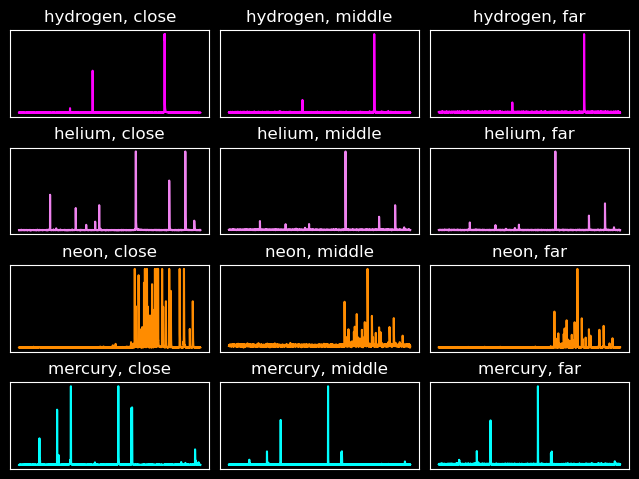

In [5]:
colors = ['magenta', 'violet', 'darkorange', 'aqua'] # color code according to lamp color

# plot spectra in 4x3 array to compare ranges for which has the most readable emission lines
fig, axs = plt.subplots(4,3)
for r, el in enumerate(elementsData):
    for c, dat in enumerate(elementsData[el]):
        axs[r, c].plot(range(len(dat)), dat, color=colors[r])
        axs[r, c].get_xaxis().set_visible(False)
        axs[r, c].get_yaxis().set_visible(False)
        title = el + ', ' + positions[c]
        axs[r, c].set_title(title)

plt.tight_layout(pad = 0.75)
plt.show()

To determine the wavelengths corresponding to each line, we need to see the relative intensities of as many lines as possible, therefore we cannot use overexposed spectra where multiple lines have maxed out the intensity measurement, nor can we use underexposed spectra where lines are indistinguishable from the background. Therefore, based on the above comparison, we should use the close spectrum for hydrogen and the middle spectra for the other elements.

In [6]:
# define arrays of the centroids and wavelengths of the major emission lines of each element
# this is done manually because the ranges for centroid computation are manually selected and all the wavelengths are constants
yH = np.array([434.0462, 486.13615, 656.28518]) 
xH = nCentroids(elementsData['hydrogen'][0], 3)

yHe = np.array([587.56, 667.82, 706.52])
xHe = nCentroids(elementsData['helium'][1], 3)

yNe = np.array([585.25, 614.31, 640.97])
xNe = nCentroids(elementsData['neon'][1], 3)

yHg = np.array([435.83, 546.07, 579.07])
xHg = nCentroids(elementsData['mercury'][1], 3)

In [7]:
xAll = np.concatenate([xH, xHe, xNe, xHg]) # creates a 1D array of all the computed centroids
yAll = np.concatenate([yH, yHe, yNe, yHg]) # creates a 1D array of all the emission line wavelengths
m, b = leastSquaresFit(xAll, yAll) # compute the fit parameters

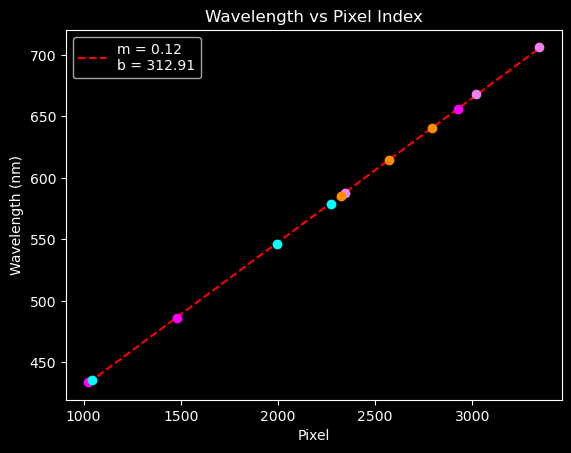

In [8]:
# plot centroid-wavelength pairs for each element, color-coded with the lamp's appearance
plt.scatter(xH, yH, color=colors[0])
plt.scatter(xHe, yHe, color=colors[1])
plt.scatter(xNe, yNe, color=colors[2])
plt.scatter(xHg, yHg, color=colors[3])

# plot the least squares fit line
x = np.arange(xAll.min(), xAll.max(), dtype=float) # I have to do this because the line style doesn't work without it for some indiscernable reason
plt.plot(x, m*x + b, 'r--', label=('m = %.2f\nb = %.2f' % (m, b)), zorder=0) 

# labeling
plt.title('Wavelength vs Pixel Index')
plt.xlabel('Pixel')
plt.ylabel('Wavelength (nm)')
plt.legend()

plt.show()

In [9]:
# define conversion function for convenience later on
def pxToWavelength(px):
    return m*px + b

## Examples/Tests

### Example of accessing spectra in elementsData

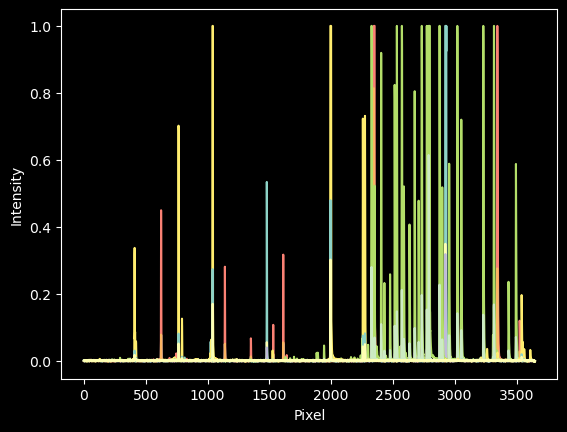

In [10]:
for el in elementsData: # el is a str, looping through each of the keys in elementsData
    for dat in elementsData[el]: # accesses the 2D array for given element key el, looping through each position
        plt.plot(range(len(dat)), dat) # plotting to show that accessing the data in this way results in the array dat being the expected 1xn array of intensities

plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.show()

In [11]:
print(np.shape(elementsData['hydrogen']))

(3, 3648)


### Centroid function test

2927.2200827712995


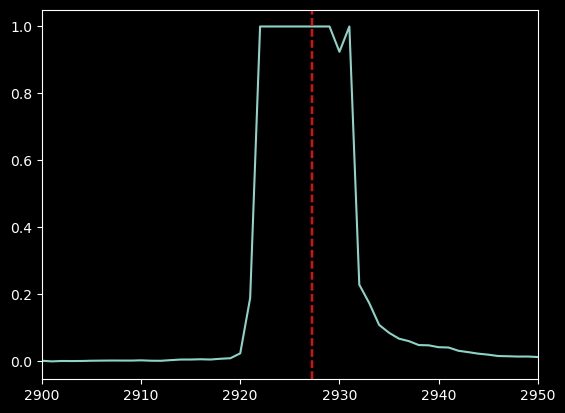

In [12]:
plt.plot(range(len(elementsData['hydrogen'][0])), elementsData['hydrogen'][0])
cen = centroid(elementsData['hydrogen'][0],(2900,2950)) # using the optional bounds parameter to find the centroid of the emission line between pixels 2900 and 2950
print(cen)
plt.axvline(cen, color='red', linestyle='--')
plt.xlim(2900, 2950)
plt.show()

### nCentroids function tests

In [13]:
arr = elementsData['hydrogen'][0]

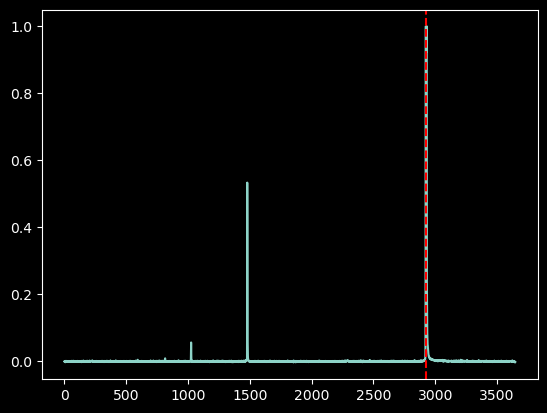

In [14]:
centroids = []
centroids.append(nCentroids(arr)) # should return a single centroid at the index of the largest peak

plt.plot(range(len(arr)), arr)
for c in centroids:
    plt.axvline(c, color='red', linestyle='--')

plt.show()

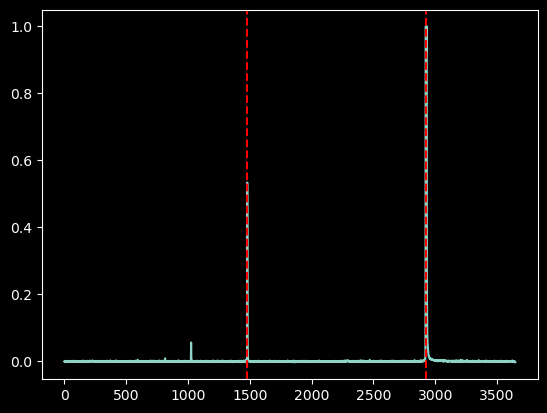

In [15]:
centroids = nCentroids(arr, 2) # should return centroids of the two largest peaks

plt.plot(range(len(arr)), arr)
for c in centroids:
    plt.axvline(c, color='red', linestyle='--')

plt.show()

6


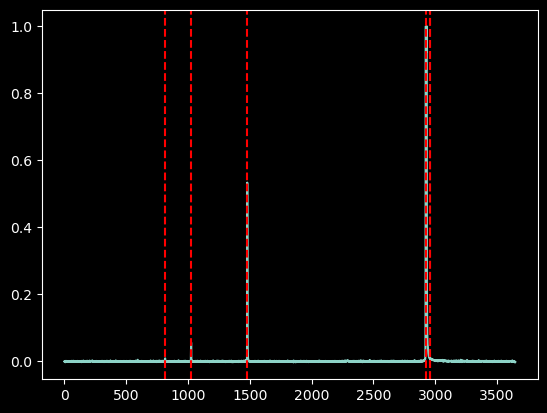

In [16]:
centroids = nCentroids(arr, background=arr[1550:2850], nsigma=10) # return centroids of peaks higher than 10 standard deviations above the mean based on the provided background
#Because the background has low noise, this picks up a lot of peaks unless nsigma is large
print(len(centroids))

plt.plot(range(len(arr)), arr)
for c in centroids:
    plt.axvline(c, color='red', linestyle='--')

plt.show()

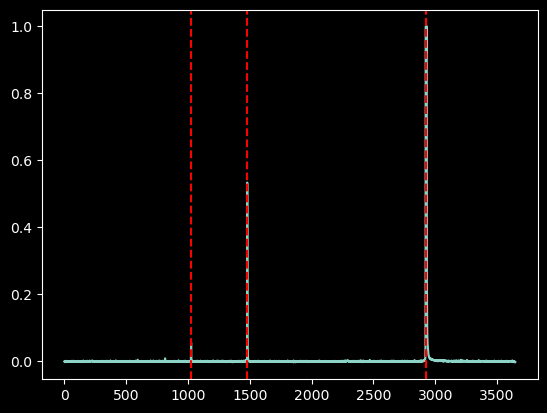

In [17]:
centroids = nCentroids(arr, cutoff=0.05) # should return centroids of all peaks greater than 0.05

plt.plot(range(len(arr)), arr)
for c in centroids:
    plt.axvline(c, color='red', linestyle='--')

plt.show()

In [18]:
centroids = nCentroids(arr, 2, background=arr[1550:2850]) # should return centroids of the two largest peaks and send a warning
print(len(centroids))

2


C:\Users\Null\AppData\Local\Temp\ipykernel_10020\680662524.py:14: UserWarning: background and cutoff are ignored when n is provided
  warn('background and cutoff are ignored when n is provided')


In [19]:
centroids = nCentroids(arr, 2, cutoff = 0.1) # should return centroids of the two largest peaks and send a warning
print(len(centroids))

2


C:\Users\Null\AppData\Local\Temp\ipykernel_10020\680662524.py:14: UserWarning: background and cutoff are ignored when n is provided
  warn('background and cutoff are ignored when n is provided')


In [20]:
centroids = nCentroids(arr, 2, background=arr[1550:2850], cutoff=0.1) # should return centroids of the two largest peaks and send a warning
print(len(centroids))

2


C:\Users\Null\AppData\Local\Temp\ipykernel_10020\680662524.py:14: UserWarning: background and cutoff are ignored when n is provided
  warn('background and cutoff are ignored when n is provided')


In [21]:
centroids = nCentroids(arr, background=arr[1550:2850], cutoff=0.6) # should return centroids of peaks above the cutoff and send a warning
print(len(centroids))

1


C:\Users\Null\AppData\Local\Temp\ipykernel_10020\680662524.py:46: UserWarning: background is ignored when cutoff is provided
  warn('background is ignored when cutoff is provided') # priority of use: n > cutoff > background


### Fitting function test

Text(5, 15, 'm = 1.007\nc = -0.208')

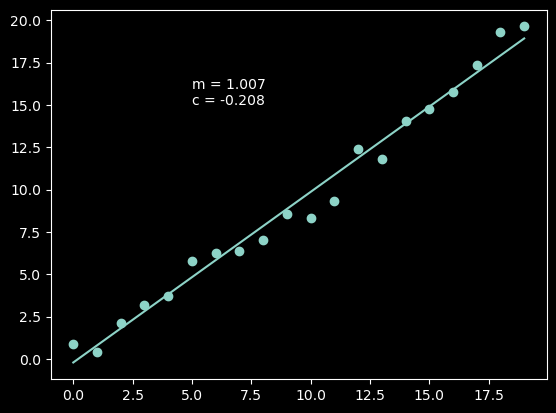

In [22]:
m = 1
c = 0

x = np.arange(20, dtype=float)
#np.random.seed(1)
y = m*x + c + np.random.randn(20)

mfit, cfit = leastSquaresFit(x,y)

plt.scatter(x, y)
plt.plot(x, mfit*x + cfit)
plt.text(5,15,'m = {:.3f}\nc = {:.3f}'.format(mfit,cfit))